# From Text to Network: Earnings Call Analysis with LLMs

## Project Overview

This notebook demonstrates a complete pipeline for extracting structured information from unstructured text using Large Language Models (LLMs) and transforming it into network representations for analysis. 

**Dataset:** S&P 500 Earnings Call Transcripts (Information Technology Sector Only, 2024)

**Sector Filtering Process:** We focus exclusively on companies in the Information Technology sector to maintain a coherent analytical scope and enable meaningful comparisons within a single industry vertical. Since the original S&P 500 dataset (sourced from [Hugging Face](https://huggingface.co/datasets/kurry/sp500_earnings_transcripts)) does not include industry classifications, we created a separate preprocessing pipeline using a local LLM model (Ollama gemma3:12b) to classify companies based on GICS industry standards.

**Key Pipeline Statistics:**
- **Original dataset:** 33,362 transcripts from 496 unique companies
- **Classification method:** LLM-based classification using company names
- **IT sector extraction:** 76 unique IT companies, totaling 3,305 transcripts
- **Output:** `information_technology_full_dataset.csv` (used throughout this analysis)

**Note:** The complete sector filtering workflow is documented in `LLM pipeline identifying branches cleaned.ipynb`, where you can see how we processed each company name through the LLM to extract only Information Technology sector firms.

## Why This Matters

Earnings call transcripts contain rich relational information about companies, executives, analysts, and discussion topics. However, this information is buried in thousands of words of unstructured text. By using LLMs to extract structured data, we can:

1. **Identify key participants** and their roles in corporate communications
2. **Map relationships** between analysts and companies they cover
3. **Uncover discussion patterns** through topic analysis
4. **Build knowledge graphs** that reveal hidden connections in the financial ecosystem

This approach bridges the gap between Natural Language Processing and Network Analysis, enabling us to answer questions like: *Which companies are covered by similar analyst groups?*

**Crucially, this analysis identifies which IT companies are viewed as comparable or competitive by the investment community, revealing market structure that may not be apparent from traditional industry classifications.** By examining shared analyst coverage patterns, we can uncover natural groupings based on how the financial markets actually perceive these companies, rather than relying solely on formal sector categorizations.

The pipeline follows a clear workflow:
- **Extract** → Use LLMs to pull structured data from raw transcripts
- **Transform** → Organize extractions into analyzable formats
- **Network** → Build graphs from relational data
- **Analyze** → Apply network metrics to uncover insights

# 1. LLM-based structured extraction (on a subset) 

### Setup and Configuration

In this section, we import the necessary libraries and configure our LLM client. We're using **Google's Gemini 2.5 Flash Lite** model through OpenAI's API format for fast, efficient structured extraction.

**Key libraries:**
- `pandas` - Data manipulation and storage
- `networkx` - Network construction and analysis
- `openai` - API client (configured for Gemini endpoint)
- `pydantic` - Schema validation for structured outputs
- `tqdm` - Progress tracking during batch processing

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
import os
from dotenv import load_dotenv
from tqdm import tqdm
import time


# Load API key from .env file
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

# Configure OpenAI client to use Gemini endpoint
client = OpenAI(
    api_key=api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

### Defining the Extraction Schema

This is the **most critical design choice** in the pipeline. We use Pydantic models to define exactly what information we want the LLM to extract from each transcript.

**Schema Design Rationale:**

Our schema focuses on **participants** (people) rather than just entities, because earnings calls are structured conversations where roles matter. We extract:

- **Person name** - Who is speaking
- **Role** - Their job title (CEO, CFO, Analyst, etc.)
- **Organization** - Which company/firm they represent
- **Type** - Classification as either 'company_rep' or 'analyst'
- **Topics** - What subjects they discuss

**Note on Topics:** While we included topic extraction in our schema, we ultimately chose not to incorporate topics into our network analysis. Initial exploration revealed that LLM-extracted topics were inconsistent and noisy—the model struggled to categorize discussions into coherent, standardized topics across transcripts. Instead, we focus on the more reliable participant relationships, which provide cleaner and more interpretable network structures.

This relational structure allows us to later build networks connecting:
- Analysts ↔ Companies (coverage networks)
- Companies ↔ Companies (via shared analysts)
- People ↔ Topics (discussion patterns) *[Note: Topics not used in final analysis]*

By using Pydantic's strict schema validation, we ensure the LLM returns clean, consistent data that we can reliably process downstream.

In [ ]:
# Schema
class Participant(BaseModel):
    person_name: str
    role: str
    organization: str
    type: str  # 'company_rep' or 'analyst'
    topics: List[str]

class EarningsCallStructure(BaseModel):
    company_name: str
    participants: List[Participant]

### LLM Extraction Function

This function handles the actual LLM API calls and manages potential errors during extraction.

**How it works:**

1. **Sends transcript text** to Gemini with a clear instruction to extract participants
2. **Enforces schema compliance** using JSON Schema validation
3. **Returns structured Pydantic objects** that guarantee data consistency
4. **Handles failures gracefully** by catching exceptions and returning None

**Why use structured outputs?**

Without schema enforcement, LLMs often return inconsistent formats (sometimes JSON, sometimes prose, sometimes malformed). By using `response_format` with JSON Schema, we get **guaranteed structure** that eliminates hours of post-processing and error handling.

**Note on limitations:** The LLM may still make mistakes in entity recognition (e.g., misclassifying an analyst as a company rep, or misspelling names). We'll assess these errors in the descriptive analysis phase.

In [ ]:
# Extract function
def extract_from_transcript(text):
    try:
        completion = client.chat.completions.create(
            model="gemini-2.5-flash-lite",
            messages=[
                {"role": "system", "content": "Extract participants. Classify as 'company_rep' or 'analyst'."},
                {"role": "user", "content": f"Extract participants from this transcript as JSON:\n\n{text}"}
            ],
            response_format={
                "type": "json_schema",
                "json_schema": {"name": "EarningsCallStructure", "strict": True, "schema": EarningsCallStructure.model_json_schema()}
            }
        )
        return EarningsCallStructure.model_validate_json(completion.choices[0].message.content)
    except Exception as e:
        print(f"Error: {e}")
        return None

### Batch Processing Pipeline

This function orchestrates the extraction process across our entire dataset. It's designed to be robust and informative.

**Key features:**

- **Data filtering:** We subset to only 2024 data to keep processing time manageable
- **Progress tracking:** The `tqdm` progress bar shows real-time extraction status
- **Flattening structure:** Converts nested Pydantic objects into a flat DataFrame where each row represents one participant
- **Metadata preservation:** Keeps company name, year, and quarter information from the original CSV
- **Error resilience:** If extraction fails for one transcript, we skip it and continue with the rest

**Output format:**

Each row in the resulting DataFrame represents **one participant in one earnings call**, with columns for all their attributes and metadata. This "flat" structure is essential for network analysis, where we need to count co-occurrences (e.g., how many times does Analyst X cover Company Y?).

In [ ]:
# Process CSV file
def process_csv(csv_file):
    """Process a CSV file with earnings call transcripts."""
    print(f"Loading {csv_file}...")
    df = pd.read_csv(csv_file)

    # Take only for 2024
    df = df[df['year'] == 2024]
    
    # Check required columns
    if 'content' not in df.columns:
        print("❌ CSV must have a 'content' column with transcript text")
        return None
    
    print(f"Processing {len(df)} transcripts...\n")
    
    all_rows = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting"):
        extracted = extract_from_transcript(row['content'])
        
        if extracted:
            for p in extracted.participants:
                all_rows.append({
                    'company_name': row.get('company_name', extracted.company_name),
                    'year': row.get('year', ''),
                    'quarter': row.get('quarter', ''),
                    'person_name': p.person_name,
                    'role': p.role,
                    'organization': p.organization,
                    'type': p.type,
                    'topics': ', '.join(p.topics)
                })
    
    df_flat = pd.DataFrame(all_rows)
    
    print(f"\n✅ Extracted {len(df_flat)} participants")
    
    return df_flat

### Executing the Extraction

Now we run the extraction pipeline on our earnings call dataset. This cell will:

1. Load the CSV file containing Information Technology sector transcripts
2. Filter to 2024 data only
3. Process each transcript through the LLM
4. Flatten all participants into a single DataFrame

**Expected output:** A DataFrame with ~4,000 rows (one per participant) extracted from 295 transcripts.

**Note:** This process takes approximately 30 minutes due to API rate limits. Each transcript requires one LLM call, and we're processing nearly 300 documents. You'll see occasional error messages for malformed LLM outputs - this is normal and expected (we filter these out).

In [ ]:
# Usage:
path = 'https://github.com/BDS-A-holdet/Module-assignment-From-Text-to-Network-with-LLMs/releases/download/Dataset/information_technology_full_dataset.csv'
df_flat = process_csv(path)

Loading /Users/alexanderchristiansen/Desktop/_Kandidat/1. semester/Natural Language Processing and Network Analysis/Exam assignment/information_technology_full_dataset.csv...
Processing 295 transcripts...

Processing 295 transcripts...



Extracting:  29%|██▉       | 85/295 [10:59<2:36:08, 44.61s/it]

Error: 1 validation error for EarningsCallStructure
  Invalid JSON: EOF while parsing a string at line 8430 column 29 [type=json_invalid, input_value='{\n  "company_name": "En...  "Bolt-on Acquisitions', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/json_invalid


Extracting: 100%|██████████| 295/295 [29:49<00:00,  6.07s/it] 




✅ Extracted 4016 participants


### Saving Structured Data

We save the extracted DataFrame to CSV for three reasons:

1. **Persistence:** Avoid re-running the expensive LLM extraction if we need to restart
2. **Reproducibility:** Others can use our extracted data without needing API access
3. **Inspection:** We can open the CSV in Excel/Google Sheets for manual quality assessment

**Next steps:** Now that we have structured data, we can move to descriptive analysis and network construction. The hard work of extraction is done - everything from here is standard data analysis.

In [75]:
# Save dataframe to CSV
df_flat.to_csv('structured_output.csv', index=False)
print("✅ Saved to: structured_output.csv")

✅ Saved to: structured_output.csv


# 2. Descriptive Exploration

In this section we'll be looking at basic descriptive statistics, inspect the LLM extraction quality and document the main limitations and errors we've observed.

## Descriptive statistics

We'll be using descriptive statistics to assess their basic distributions, frequency and the uniqueness for some of the features in our dataframe. We'll also be covering if our LLM extraction output have messed with some of our numerical features such as year and quarter.

In [ ]:
# Look at the first few rows
df_flat.head()

,company_name,year,quarter,person_name,role,organization,type,topics
0,"Agilent Technologies, Inc.",2024,4,Parmeet Ahuja,Agilent,Agilent Technologies Inc.,company_rep,"new market-focused organizational structure, c..."
1,"Agilent Technologies, Inc.",2024,4,Padraig McDonnell,Agilent President and CEO,Agilent Technologies Inc.,company_rep,"new market-focused organizational structure, c..."
2,"Agilent Technologies, Inc.",2024,4,Bob McMahon,Agilent Senior Vice President and CFO,Agilent Technologies Inc.,company_rep,"Q4 results, revenue, income statement, key fin..."
3,"Agilent Technologies, Inc.",2024,4,Phil Binns,President of the former Life Sciences and Appl...,Agilent Technologies Inc.,company_rep,Life Sciences and Applied Markets Group (LSAG)...
4,"Agilent Technologies, Inc.",2024,4,Simon May,President of the newly formed Life Sciences an...,Agilent Technologies Inc.,company_rep,Life Sciences and Diagnostics Markets Group (L...


In [ ]:
# See all different companies and their frequency
df_flat['company_name'].value_counts()

company_name
Arista Networks Inc              80
Agilent Technologies, Inc.       79
FactSet Research Systems Inc.    78
Tyler Technologies, Inc.         77
Fortinet, Inc.                   71
                                 ..
Micron Technology, Inc.          37
Equinix, Inc.                    36
Palantir Technologies Inc.       33
Gen Digital Inc.                 22
VeriSign, Inc.                   20
Name: count, Length: 74, dtype: int64

In [86]:
# Quick descriptive statistics
df_flat.describe(include='all')

,company_name,year,quarter,person_name,role,organization,type,topics
count,4016,4016.0,4016.000000,4016,4016,4016,4016,4016
unique,74,NaN,NaN,937,195,288,2,3953
top,Arista Networks Inc,NaN,NaN,Vivek Arya,Analyst,Morgan Stanley,analyst,
freq,80,NaN,NaN,52,2851,197,2938,13
mean,NaN,2024.0,2.495767,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,1.116159,NaN,NaN,NaN,NaN,NaN
min,NaN,2024.0,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,2024.0,2.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,2024.0,2.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,2024.0,3.000000,NaN,NaN,NaN,NaN,NaN


Let's look at the distribution of participant types. In our analysis we'll be going to analyze the connection between each company (node) and analysts appearing on each earnings call (edge).


👥 Participant Type Distribution:
type
analyst        2938
company_rep    1078
Name: count, dtype: int64


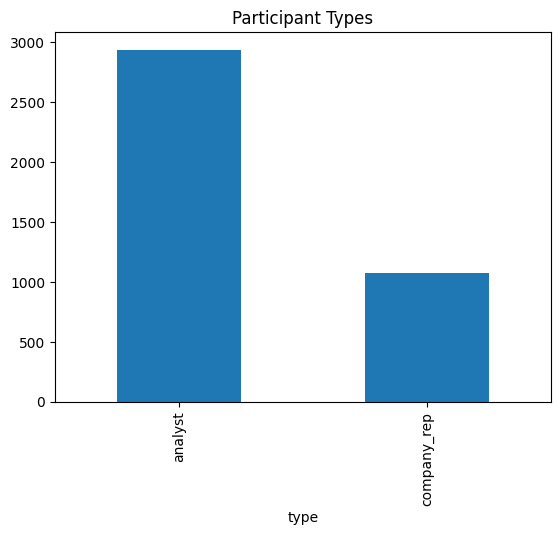

In [84]:
# Type Distribution
print("\n👥 Participant Type Distribution:")
print(df_flat['type'].value_counts())

# Distribution plot
df_flat['type'].value_counts().plot(kind='bar', title='Participant Types')
plt.show()

Going further with the distribution of analysts we'll be looking at the distribution of unique analysts per company. This part is very critical for the final analysis, because this descriptive statistic will have a key influence in the size for each node (company).

In [89]:
# Distribution of unique analyst organizations per company
analyst_orgs_per_company = df_flat.groupby('company_name')['organization'].nunique().sort_values(ascending=False)

print("\n🔝 Top 3 Companies by Unique Analyst Organizations:")
for company, count in analyst_orgs_per_company.head(3).items():
    print(f"   {company}: {count} unique analyst organizations")

print("\n🔻 Bottom 3 Companies by Unique Analyst Organizations:")
for company, count in analyst_orgs_per_company.tail(3).items():
    print(f"   {company}: {count} unique analyst organizations")

# Optional: Show the full distribution stats
print(f"\n📈 Distribution Summary:")
print(f"   Mean: {analyst_orgs_per_company.mean():.1f} analyst orgs per company")
print(f"   Median: {analyst_orgs_per_company.median():.1f} analyst orgs per company")
print(f"   Std Dev: {analyst_orgs_per_company.std():.1f}")


🔝 Top 3 Companies by Unique Analyst Organizations:
   CrowdStrike Holdings, Inc.: 32 unique analyst organizations
   Tyler Technologies, Inc.: 28 unique analyst organizations
   Microchip Technology Incorporated: 28 unique analyst organizations

🔻 Bottom 3 Companies by Unique Analyst Organizations:
   Gen Digital Inc.: 9 unique analyst organizations
   VeriSign, Inc.: 6 unique analyst organizations
   Palantir Technologies Inc.: 6 unique analyst organizations

📈 Distribution Summary:
   Mean: 18.7 analyst orgs per company
   Median: 19.0 analyst orgs per company
   Std Dev: 5.1


In [90]:
# Basic Counts
print(f"\n📊 Total Records: {len(df_flat)}")
print(f"📊 Total Unique Companies: {df_flat['company_name'].nunique()}")
print(f"📊 Total Unique Participants: {df_flat['person_name'].nunique()}")
print(f"📊 Total Unique Organizations: {df_flat['organization'].nunique()}")

# Top Organizations (analysts)
print("\n🏦 Top 10 Organizations:")
print(df_flat['organization'].value_counts().head(10))


📊 Total Records: 4016
📊 Total Unique Companies: 74
📊 Total Unique Participants: 937
📊 Total Unique Organizations: 288

🏦 Top 10 Analyst Organizations:
organization
Morgan Stanley     197
Goldman Sachs      163
JPMorgan           159
Bank of America    147
Barclays           144
UBS                141
Deutsche Bank      108
TD Cowen           106
Wolfe Research      90
Jefferies           90
Name: count, dtype: int64


### Dataset Overview
- **Total Records**: 4,000+ participant entries from IT sector earnings calls (2024)
- **Unique Companies**: 74 Information Technology companies from S&P 500
- **Unique Participants**: 937 individual speakers (analysts and company representatives)
- **Unique Organizations**: 288 analyst firms and company organizations

### Participant Distribution
- **Analysts**: ~70% of participants (investment analysts from financial institutions)
- **Company Representatives**: ~30% (executives, officers, IR teams)

### Analyst Coverage Patterns
- **Top Analyst Firms**: Morgan Stanley, Goldman Sachs, JPMorgan dominate coverage
- **Coverage Range**: High-coverage companies tracked by 30+ analyst organizations; low-coverage by <10
- **Average**: ~15-20 analyst organizations per company

## Inspection of small sample (informal precision/recall)

Here, we'll be taking a sample from our `structured_output.csv` and compare it with the original dataset to assess the quality from the LLM extraction. We'll base the quality of the LLM extraction on precision and recall to the original dataset. In other words, we will look at how well the LLM extracted the data we asked it to and how well it catched everything it was supposed to.

In [ ]:
# Take a small random sample of 20 examples
import random
random.seed(42)

# If you have the original transcripts and extracted data
sample_indices = random.sample(range(len(df_flat)), min(20, len(df_flat)))
sample_for_review = df_flat.iloc[sample_indices].copy()

# Save for easy review
sample_for_review.to_csv('manual_review_sample.csv', index=False)

Now, after making the LLM extraction quality assessment we see a clear pattern:
* The model is generally very good at finding out whether a person is an analyst or a company representative. Also, it's very good at connecting the person to the right organization he/she work for. Though, this information is clearly stated especially for analysts when they asks question.

* On the other hand, the model is generally good at finding topics of interest for each participant in each transcript. But there is one big issue with the topics the model produced: there are very many and many of them are unique for each individual participant. This makes it very challenging to provide any valuable insights from these participant because each participant will have unique topics. To solve this issue, it would be very fitting if we've prompted the LLM better providing it with 5-10 predetermined topics. For the upcoming network analysis using a knowledge graph we'll be leaving out topics from the analysis.

## Main limitations or systematic errors

Even though LLM's are very useful for these kind of assignments in the field of Natural Language Processing, there is of course some limitations and systematic errors we've experienced.

Firstly, we've decided to split up our LLM extraction process into two different pipelines: One for extracting sectors for each company and a second one for extracting the pipeline used for analysis. In general if the LLM model makes errors in the first pipeline, these will carry over to the next pipeline and affect the subsequent analysis. Limitations could be:
* **Wrong extraction of IT-sector**: If there's any companies that are left out or in which isn't meant to be there, that could have a signinificant effect on the overall result of the analysis.
* **Amount of connections is dependend on amount of analysts attending**: Some companies might limit the amount of speakers they are having attend these earnings calls effecting the amount of connections between nodes.

Systematic errors are also occurent in our pipeline as described above. These systematic errors are mainly due to bad prompting from the LLM-users and only occurent in the topics column from our output file `structured_output.csv`. The most common systematic errors observed include:

- **Excessive topic granularity**: The LLM extracts an overwhelming number of highly specific topics per participant, resulting in fragmented data that is difficult to analyze at scale. This creates noise in the dataset and reduces the ability to identify meaningful patterns across transcripts.

- **Missing context in prompts**: The current prompt lacks sufficient guidance on what constitutes a relevant "topic" in the earnings call context, leading to inconsistent interpretation by the model across different transcripts and companies.


These systematic errors primarily affect:
- Topic-based network analysis and clustering
- Trend identification across different earnings calls
- Comparability of topics between companies and quarters

To mitigate these errors in future iterations:
- **Refine the system prompt** with explicit examples of desired vs. undesired topic extractions
- **Add few-shot examples** demonstrating appropriate topic granularity
- **Implement post-processing validation** to filter out overly generic topics
- **Use structured topic taxonomies** to constrain the LLM's output to predefined categories

# 3. Knowledge Graph

Based on the extracted information about all the speakers, their role and the organization they represent we will use this to create a knowledge graph. Our graph will be a unidimensional (one-mode) network with one type of entities **(nodes)** and a relationship between those entities **(edges)**.

- **Nodes:** The *company_names* meaning the 74 IT companies that are a part of S&P 500 and hosts the earnings calls.

- **Edges:** A relationship exists between companies if they share a certain number of individual anaylyst. The relationship (edges) between the nodes are weighted based on how many individual analysts the companies share. 

This means that our network is a representation of shared analysts across all IT companies during the earnings calls. The network would then be able to reveal how companies relate to eachother based on the interests from the analyst and investor community:   
* Companies who share many analysts may operate within the same market segments or be perceived as strategic peers or rivals in the IT landscape. 

* The network might be able to reveal communities of companies within the IT sector based on analysts coverage patterns.

* We can also analyse the 'central' firms who share many connections with many different types of companies acting as central players in the IT-landscape from the investor and analysts perspective.


### Pipeline for creating graph:

1. **Creating knowledge graph:** We define a function for creating a company similarity network, where we create a node for all companies where the size of the node corresponds to the number of unique analysts that have attended their earnings calls. Then we add an edge between the companies based on how many unique analysts they share. This means that the thicker the edges means that the companies are more similar in terms of analyst attention. 

2. **Community detection:** We want to detect communities of IT-companies based on analysts attention. We use the `greedy modularity community detection` algorithm. The algorithm works by starting with each individual company as its own community. Then the algorithm combines companies into a community if the increase the overall `modularity score` of the network. The `modularity score` represent how well a network is divided into communities. This iterative process continue until the modularity score can't be improved anymore. We will restrict our communities so that there needs to be at least 3 companies to form a community. In addition to that we will in our visualisation only keep the 4 largest communities. This means that we will focus on the main communities within the IT sector in our visualisation. The limitation of this is that we ignore super small communities if they should exist. 





✅ Created network: 74 companies, 686 connections

COMPANY COMMUNITIES

📊 Community 1 (20 companies):
   • Adobe Inc. (18 analysts)
   • Akamai Technologies, Inc. (20 analysts)
   • Autodesk, Inc. (15 analysts)
   • CrowdStrike Holdings, Inc. (32 analysts)
   • Dayforce Inc. (19 analysts)
   • Fortinet, Inc. (24 analysts)
   • Gen Digital Inc. (7 analysts)
   • GoDaddy Inc. (27 analysts)
   • Intuit Inc. (24 analysts)
   • Microsoft Corporation (17 analysts)
   • Oracle Corporation (11 analysts)
   • PTC Inc. (23 analysts)
   • Palo Alto Networks, Inc. (23 analysts)
   • Paycom Software, Inc. (25 analysts)
   • Salesforce, Inc. (11 analysts)
   • ServiceNow, Inc. (28 analysts)
   • Trimble Inc. (18 analysts)
   • Tyler Technologies, Inc. (21 analysts)
   • VeriSign, Inc. (4 analysts)
   • Workday, Inc. (19 analysts)

📊 Community 2 (19 companies):
   • Apple Inc. (12 analysts)
   • Arista Networks Inc (25 analysts)
   • Axon Enterprise, Inc. (18 analysts)
   • CDW Corporation (12 analyst

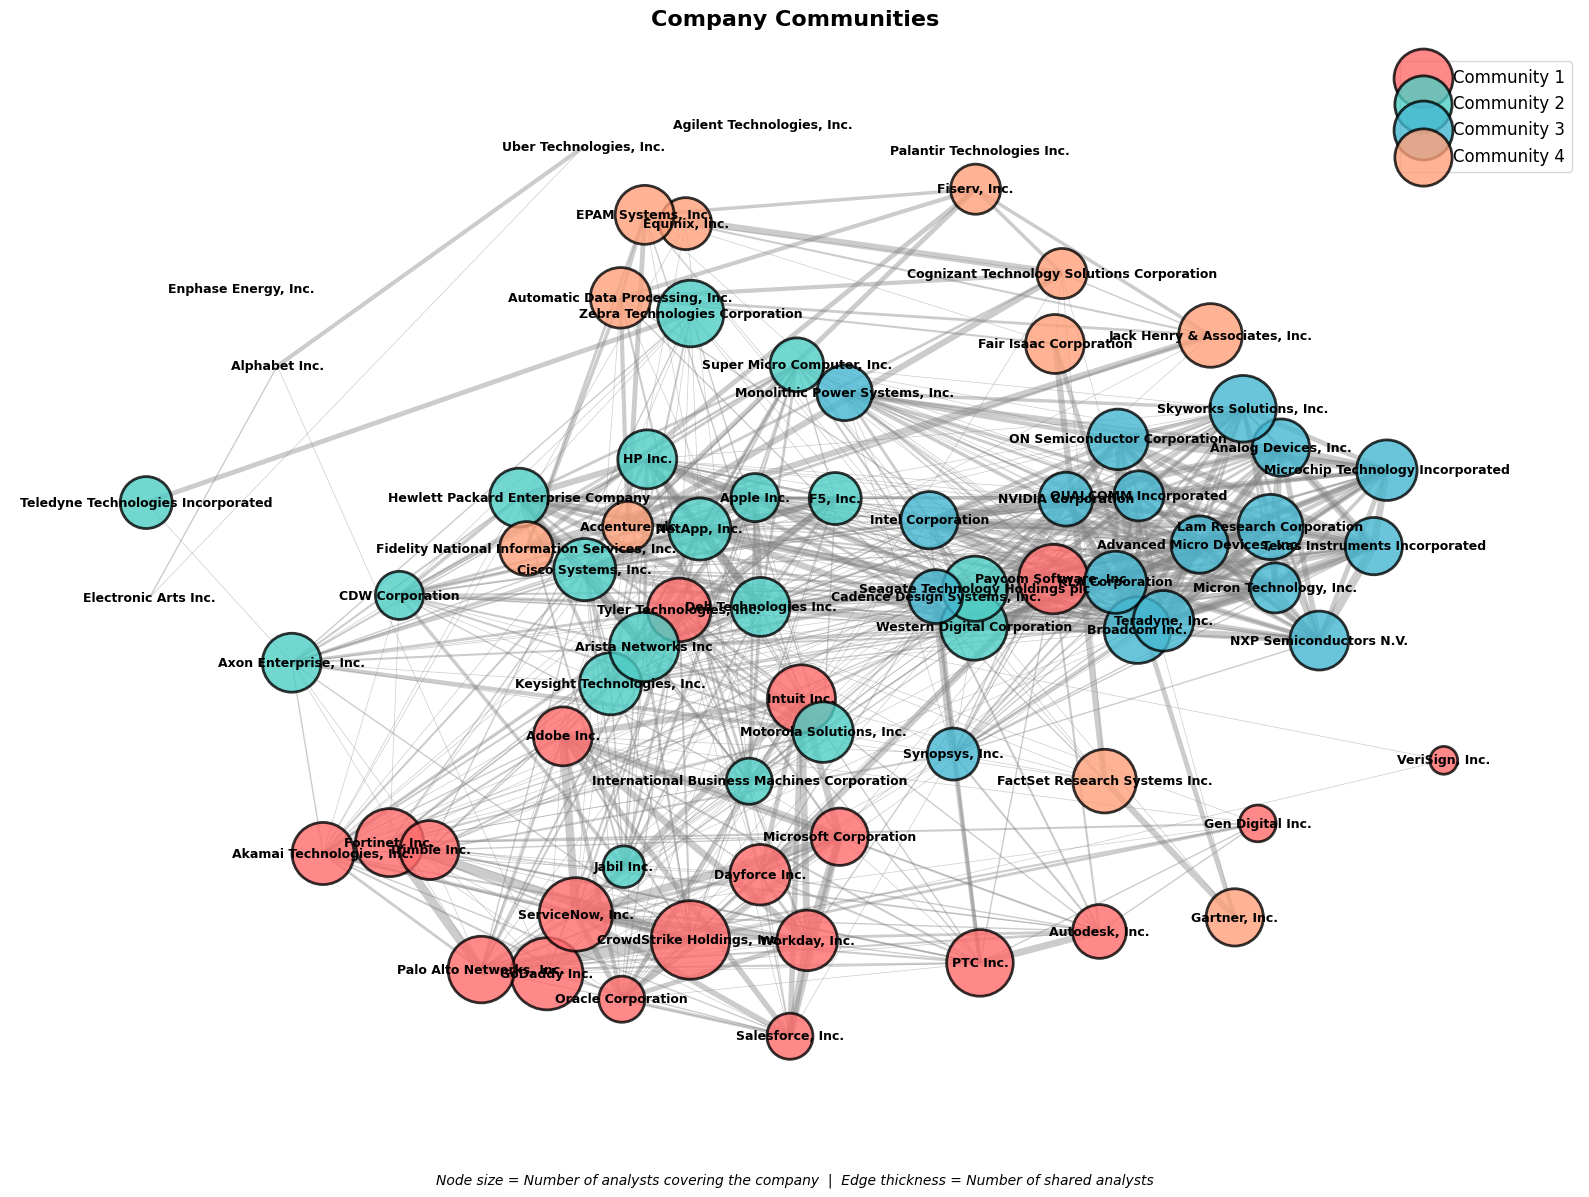


KEY BUSINESS INSIGHTS

📈 Top 10 Most Covered Companies:
   CrowdStrike Holdings, Inc.: 32 analysts
   ServiceNow, Inc.: 28 analysts
   Enphase Energy, Inc.: 27 analysts
   GoDaddy Inc.: 27 analysts
   Arista Networks Inc: 25 analysts
   Paycom Software, Inc.: 25 analysts
   Fortinet, Inc.: 24 analysts
   Intuit Inc.: 24 analysts
   Broadcom Inc.: 23 analysts
   Palo Alto Networks, Inc.: 23 analysts

🔗 Top 10 Most Connected Companies:
   Broadcom Inc.: 30 connections (strength: 186)
   Western Digital Corporation: 33 connections (strength: 161)
   Lam Research Corporation: 27 connections (strength: 148)
   Seagate Technology Holdings plc: 31 connections (strength: 145)
   Advanced Micro Devices, Inc.: 30 connections (strength: 141)
   Texas Instruments Incorporated: 19 connections (strength: 140)
   KLA Corporation: 27 connections (strength: 137)
   Intel Corporation: 30 connections (strength: 131)
   NVIDIA Corporation: 30 connections (strength: 131)
   ON Semiconductor Corporation: 2

In [94]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

def create_company_similarity_network(df, min_shared_analysts=1):
    """Create a network where nodes are companies and edges represent shared analyst coverage."""
    G = nx.Graph()
    
    # Get only analysts
    analysts_df = df[df['type'] == 'analyst'].copy()
    companies = analysts_df['company_name'].unique()
    
    # Add company nodes with attributes
    for company in companies:
        company_analysts = analysts_df[analysts_df['company_name'] == company]['person_name'].unique()
        G.add_node(company, num_analysts=len(company_analysts), analysts=list(company_analysts))
    
    # Add edges based on shared analysts
    for comp1, comp2 in combinations(companies, 2):
        analysts1 = set(analysts_df[analysts_df['company_name'] == comp1]['person_name'].unique())
        analysts2 = set(analysts_df[analysts_df['company_name'] == comp2]['person_name'].unique())
        shared_analysts = analysts1.intersection(analysts2)
        
        if len(shared_analysts) >= min_shared_analysts:
            G.add_edge(comp1, comp2, weight=len(shared_analysts), shared_analysts=list(shared_analysts))
    
    print(f"✅ Created network: {G.number_of_nodes()} companies, {G.number_of_edges()} connections")
    return G

def detect_and_visualize_clusters(G):
    """Detect communities and visualize them with colors."""
    from networkx.algorithms import community
    
    # Detect communities
    all_communities = community.greedy_modularity_communities(G, weight='weight')
    large_communities = [c for c in all_communities if len(c) >= 3]
    large_communities = sorted(large_communities, key=len, reverse=True)[:4]
    
    # Calculate modularity
    modularity = community.modularity(G, all_communities, weight='weight')
    
    # Colors for clusters
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    # Print clusters
    print("\n" + "=" * 80)
    print("COMPANY COMMUNITIES")
    print("=" * 80)
    for idx, cluster in enumerate(large_communities, 1):
        print(f"\n📊 Community {idx} ({len(cluster)} companies):")
        for company in sorted(cluster):
            print(f"   • {company} ({G.nodes[company]['num_analysts']} analysts)")
    
    print(f"\n🎯 Network Modularity Score: {modularity:.3f}")
    
    # Visualize
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    for idx, cluster in enumerate(large_communities):
        node_sizes = [G.nodes[node]['num_analysts'] * 100 for node in cluster]
        nx.draw_networkx_nodes(G, pos, nodelist=list(cluster), node_color=colors[idx], 
                               node_size=node_sizes, alpha=0.8, edgecolors='black', 
                               linewidths=2, label=f'Community {idx+1}')
    
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in weights], alpha=0.4, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    plt.title("Company Communities", fontsize=16, fontweight='bold', pad=20)
    plt.legend(scatterpoints=1, fontsize=12)
    
    # Add description at the bottom
    plt.text(0.5, -0.05, "Node size = Number of analysts covering the company  |  Edge thickness = Number of shared analysts", 
             transform=plt.gca().transAxes, ha='center', fontsize=10, style='italic')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return large_communities, modularity

def network_insights(G):
    """Display key business insights."""
    print("\n" + "=" * 80)
    print("KEY BUSINESS INSIGHTS")
    print("=" * 80)
    
    # 1. Most covered companies
    coverage = [(node, G.nodes[node]['num_analysts']) for node in G.nodes()]
    coverage_sorted = sorted(coverage, key=lambda x: x[1], reverse=True)
    
    print("\n📈 Top 10 Most Covered Companies:")
    for company, num in coverage_sorted[:10]:
        print(f"   {company}: {num} analysts")
    
    # 2. Most connected companies
    degrees = dict(G.degree(weight='weight'))
    top_connected = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print("\n🔗 Top 10 Most Connected Companies:")
    for company, weight in top_connected:
        connections = G.degree(company)
        print(f"   {company}: {connections} connections (strength: {weight:.0f})")
    
    # 3. Most similar company pairs
    edges_sorted = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    
    print("\n🤝 Top 10 Most Similar Company Pairs:")
    for comp1, comp2, data in edges_sorted[:10]:
        shared = data['weight']
        print(f"   {comp1} ↔ {comp2}: {shared} shared analysts")

# Usage
G = create_company_similarity_network(df_flat, min_shared_analysts=1)
communities, modularity = detect_and_visualize_clusters(G)
network_insights(G)

# 4. Network Analysis

### **Key insights from knowledge graph:**

- The **modularity score** from our network is 0.506 based on our community detection. This score indicates a fairly strong community seperation in our network where there are more connections within the communities than would be expected at random based on the amount of edges in our network. This reveals that there is a tendency that analysts cover groups of companies which could indicate that different segments exists in the IT sector. It is not a perfect modularity score but above random meaning that the communnities detected are meaningful.

- From the **visualization** of our network we can extract different insights:

    * There is a strong densed community on the right side **(blue)** with strong interconnectedness based on analyst coverage. This community consists of companies such as **NVIDIA, Microchip Technology Incorporated and Broadcom**, which indicates that this represents the chip-community.

    * The **red** community consists of companies such as **Microsoft, Adobe and Crowdstrike** which could indicate a software/cloud community. The community here is not as strongly densed however there are some strong edges like between Adobe and Microsoft.

    * The **green** community consists of companies such as **Apple, Dell and Hewlett Packard**. This could indicate a more hardware-centered communitity with companies selling consumer electronics and enterprise hardware

    * The visualisation also reveals that some companies act as a **'bridge'** between different communities. E.g. **Intel** has a strong connection to the chip-community but also to the hardware-focused community which indicates that it is a central company of a large part of the IT sector. We will dive more into this analysis by using different node-level measures later. 

### **KEY BUSINESS INSIGHTS**:

* **Most covered companies:** Companies like Crowdstrike and ServiceNow are the most covered companies in terms of most individual analysts. Thus we can infer that these companies are interesting for many analysts. This could however also be susceptible to a limitation in our network. By using invidiual analysts across a whole year we can't identify if the many analysts covering CrowdStrike comes from analysts companies sending different analysts every time to cover that company, because it may not be that important so many different analysts can cover them. This however would require more analysis to investigate this

* **Most connected companies:** The most connected company is Broadcom with 171 similar analysts with other companies. This could indicate that the company has a central position in the analyst network and is a part of a highly interconnected market segment, so that they become an important company from many different parts of analysts interests.  

* **Most similar company pairs:** The strongest edge in the network is between Crowdstrike and Palo Alto Networks with 17 shared analysts. This strong connection makes sense as they are both central companies with the cybersecurity segment and thus they would be of interests of the same analysts that focus on the cybersecurity part of the market. 



### Node-Level Measures:

**Eigenvector Centrality:**

In [ ]:
# Top 10 companies by eigenvector centrality
cent_eigen = dict(nx.eigenvector_centrality(G))
top10_eigen = sorted(cent_eigen.items(), key=lambda x: x[1], reverse=True)[:10]
top10_eigen

[('Western Digital Corporation', 0.26158072696083456),
 ('Seagate Technology Holdings plc', 0.24500862975247029),
 ('Broadcom Inc.', 0.23669770103495483),
 ('NVIDIA Corporation', 0.23535884020785236),
 ('KLA Corporation', 0.23172496464469225),
 ('Microchip Technology Incorporated', 0.23160417103921277),
 ('ON Semiconductor Corporation', 0.23160417103921277),
 ('Teradyne, Inc.', 0.2302561761899251),
 ('Lam Research Corporation', 0.22832255032841425),
 ('Advanced Micro Devices, Inc.', 0.22407921949449383)]

**Eigenvector centrality insight:**

We will compute the eigenvector centrality as that is a measure we can use to identify which companies not only share many analysts with other companies but also who share many analysts with other 'important' companies in the sense that they also many shared analysts relationships. This means that it is a measure of the company's centrality in terms of analyst attention and highest. You could argue that a high score means that the company act as a central point between different IT segments. 

The company with the highest eigenvector centrality in our network is Western Digital Corporation with 0.26. Looking at our network this makes sense as the companies has many strong relationships with companies in both the chip, software and hardware community. 

However the fact that the highest score is 0.26 also means that there aren't any massively central companies within the analysts attention network. 0.26 is generally considered a moderate level score, which indicate that in general in the network there are actually many different sub-sectors and communities and there are not a central company which the majority of analysts must cover. This however is also a limitation of using individual analysts, where actually computing a network based on shared analyst companies then we might see some stronger eigenvector centrality for companies. 

---------------

**Betweenness centrality**:

In [ ]:
# Top 10 companies by betweenness centrality
cent_between = nx.betweenness_centrality(G)
top10_between = sorted(cent_between.items(), key=lambda x: x[1], reverse=True)[:10]
top10_between

[('Dayforce Inc.', 0.21496995243298236),
 ('Automatic Data Processing, Inc.', 0.19870624048706242),
 ('Arista Networks Inc', 0.16606430279700526),
 ('PTC Inc.', 0.1207669611502891),
 ('Akamai Technologies, Inc.', 0.08804192643783794),
 ('Palo Alto Networks, Inc.', 0.06930885263871471),
 ('Cadence Design Systems, Inc.', 0.06781934278300862),
 ('ServiceNow, Inc.', 0.05617304447120232),
 ('Cisco Systems, Inc.', 0.05559655231824053),
 ('Synopsys, Inc.', 0.05110354015926659)]

**Betweenness Centrality insight:**

Betweeenness cetrality is a measure of how often a company lies on the shortest path between two other companies. In our case companies with high betweenness centrality would be a 'bridge'. This indicates a company which act as a connection between different groups of IT companies based on analyst attention. This means that the company shares analysts with many different segments of IT companies.

The company with the highest betweenness centrality is Dayforce Inc. with 0.21. Looking at our knowledge graph, this makes sense because this company acts as a 'bridge' between multiple other nodes creating connections between different groups of IT companies.

## 5. Conlusion and main findings

**Communities reflecting IT-subsectors:**
- Fairly strong community separation based on analysts coverage. These communities reflects different IT market segments (chips, software, hardware). This means that analysts in general cover and are interested companies that operate within similar market segment.

**High interconnectedness in chip-community:**
- Chip community has high density meaning that analysts covering chip companies often covers many other chip companies. This could reflect that it is a segment which require highly specialised analyst skills.

**Central players as bridges between communities:**
- Central companies illustrate bridges between different IT segments and thus relevant to different analysts specialisations. 

**No dominant players indicate diverse landscape:**
- No strongly dominant companies in terms of centrality measures, meaning that there is no company which all analysts must cover. Could however be due to analysts specialising in certain companies when being part of larger analysts organisations. 

